In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re


PREFIX='a video of '
events = [
    "Riding",
    "Fighting",
    "Playing",
    "Running",
    "Lying",
    "Chasing",
    "Jumping",
    "Falling",
    "Guiding",
    "Stealing",
    "Littering",
    "Tripping",
    "Pickpockering",
]
description = [
        "a person riding a bicycle",
        "a certain number of persons fighting",
        "a group of persons playing",
        "a person running",
        "a person lying in the floor",
        "a person chasing other person",
        "a person jumping",
        "a person falling",
        "a person guiding other person",
        "a person stealing other person",
        "a person throwing trash in the floor",
        "a person tripping",
        "a person stealing other person's pocket",
    ]
normal_prompt = "a normal view (persons walking or standing)"
description.append(normal_prompt)
description=[PREFIX +desc for desc in description]
events_description = {event: desc for event, desc in zip(events, description)}

In [3]:
def selection_events(events_score, events_answer, verbose=False):
    threshold = 60
    events_score.pop(PREFIX+normal_prompt)
    # Step 1: Find the maximum score
    max_score = max(events_score.values())
    # Step 2: Filter events that have the max score
    #top_events = [event for event, score in events_score.items() if score == max_score]
    top_events = [event for event, score in events_score.items() if score == max_score and events_answer[event] == "Yes"]
    # Result
    if max_score<threshold or len(top_events)==0:
        return [PREFIX+normal_prompt]
    if verbose:
        print("Max score:", max_score)
        print("Events with max score:", top_events)
    return top_events


def check_class(prompts, events, verbose=False):
    verbose=True
    if verbose:
        print('Starting\n')
    if prompts== "":
        return [PREFIX+normal_prompt]
    events_score=dict()
    events_answer=dict()
    for j in range(len(events)):
        # Extract "Yes" and "100" using capturing groups
        pattern = r'Answer:\s*(?:\[)?(.*?)(?:\])?\nScore:\s*(?:\[)?(\d+)(?:\])?'
        #print('Prompt:',prompts[i], '\nPredicted:',events[i],'\n')
        match = re.search(pattern, prompts[j])
        if match:
            answer = match.group(1)  # "Yes"
            score = int(match.group(2))  # 100 (converted to integer)
            events_score[events[j]] = score
            events_answer[events[j]] = answer
            #print(f'{j} Event:{events[j]}')
            if verbose:
                print(f"Answer: {answer}, Score: {score}, Event: {events[j]}\n")
    selected_events = selection_events(events_score, events_answer)
    if verbose:
        print(f'Returning {selected_events}\n\n')
    return selected_events
def check_precision(frames_number, video_name, predicted_events, event, anomaly_classes, prompts, mode):
    # TN Prediction and Reality are true
    # TN Prediction and Reality are false
    # FN Prediction is false and Reality is true
    # FP Prediction is true and Reality is false
    normal_class = PREFIX + "a normal view (persons walking or standing)"
    all_classes = anomaly_classes
    frames = np.load("/home/ubuntu/Database/ALL/GT/gt_ALL.npz")
    frames= frames[video_name]
    frames = np.append(frames, frames[-1])
    # Create a dictionary to convert class names to numeric indices
    class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
    # Example: {"a normal view...": 0, "a person riding...": 1, ...}
    num_classes = len(all_classes)  # 14
    cm = np.zeros((num_classes, num_classes), dtype=int)
    #prompts = [prompt.lower().split('.')[0] for prompt in prompts]
    # Save frames_number, predicted_events, and prompts into a numpy array)
    for i in range(len(prompts)):
        is_anomaly = frames[frames_number[i] - 1]  # 0 or 1
        # Determine true class using EVENT when anomaly exists
        true_class = event if is_anomaly == 1 else normal_class
        #pred_class = predicted_events[i]
        # Get ground truth
        #print(pred_class)
        '''if pred_class is not None:
            pass
        else:
            continue'''
        print(frames_number[i]/30,'-',frames[frames_number[i] - 1],'-')
        selected_events=check_class(prompts[i], predicted_events[i])
        for pred_class in selected_events:
            # Convert to indices (skip if class not recognized)
            true_idx = class_to_idx.get(true_class, -1)
            pred_idx = class_to_idx.get(pred_class, -1)
            
            if true_idx != -1 and pred_idx != -1:
                cm[true_idx, pred_idx] += 1
    # Get the index of your event class
    event_idx = class_to_idx[event]
    

    # Calculate metrics ONLY for your event class
    tp = cm[event_idx, event_idx]  # TNs for event
    fp = np.sum(cm[:, event_idx]) - tp  # FPs (other classes predicted as event)
    fn =  np.sum(cm[event_idx, :]) - tp  # FNs (event misclassified as others)
    tn = np.sum(cm) - tp - fp - fn  # TNs
    return tp, fp, fn, tn, cm

rute_stored='/home/ubuntu/Tesis/Storage/M4MulticlassNMS'
files=os.listdir(rute_stored)
files = [f for f in files if f.endswith('.npy')]
all_prompts = []
all_description = []
df= pd.DataFrame(columns=['Name', 'Event', 'Mode', 'TP', 'FP', 'FN', 'TN'])
prompts_number=0
class_to_idx = {cls: idx for idx, cls in enumerate(description)}
# Example: {"a normal view...": 0, "a person riding...": 1, ...}
num_classes = len(description)  # 14
cm_sum = np.zeros((num_classes, num_classes), dtype=int)
#Number of file
file= files[2]
file='1_080_1_CLIP_3_a video of a person throwing trash in the floor.npy'
#file='4_110_1_CLIP_3_a video of a person running.npy'
#print(file)
name= file.split('_CLIP_')[0]
mode=file.split('_CLIP_')[1][0]
event=file.split('_CLIP_')[1][2:].split('.')[0]
info_stored=np.load(f"{rute_stored}/{file}", allow_pickle=True)
frames_number=info_stored[0]
predicted_events=info_stored[1]
#print(predicted_events)
prompts=info_stored[2]
all_prompts += list(prompts)
all_description+= list(predicted_events)
prompts_number += len(prompts)
tp, fp, fn, tn, cm= check_precision(frames_number, name, predicted_events, event, description, prompts, mode)
cm_sum += cm
row = {
'Name':name, 'Event':event, 'Mode':mode, 'TP':tp, 'FP':fp, 'FN':fn, 'TN':tn
}
df =pd.concat([df, pd.DataFrame([row])], ignore_index=True) 

1.1666666666666667 - 0.0 -
Starting

Answer: Yes, Score: 70, Event: a video of a person running

Answer: No, Score: 0, Event: a video of a person lying in the floor

Answer: Yes, Score: 75, Event: a video of a normal view (persons walking or standing)

Returning ['a video of a person running']


1.3333333333333333 - 0.0 -
Starting

Answer: No, Score: 60, Event: a video of a person running

Answer: No, Score: 0, Event: a video of a person lying in the floor

Answer: Yes, Score: 80, Event: a video of a normal view (persons walking or standing)

Returning ['a video of a normal view (persons walking or standing)']


1.5 - 0.0 -
Starting

Answer: No, Score: 0, Event: a video of a person running

Answer: No, Score: 0, Event: a video of a person lying in the floor

Answer: Yes, Score: 75, Event: a video of a normal view (persons walking or standing)

Returning ['a video of a normal view (persons walking or standing)']


1.6666666666666667 - 0.0 -
Starting

Answer: No, Score: 0, Event: a video

In [ ]:
print(df)


      Name                        Event Mode TP  FP  FN  TN
0  3_090_1  a video of a person running    3  0  15  29  70


/tmp/ipykernel_50483/341241949.py:2: RuntimeWarning: invalid value encountered in divide
  cm_sum = cm_sum / cm_sum.sum(axis=1, keepdims=True)


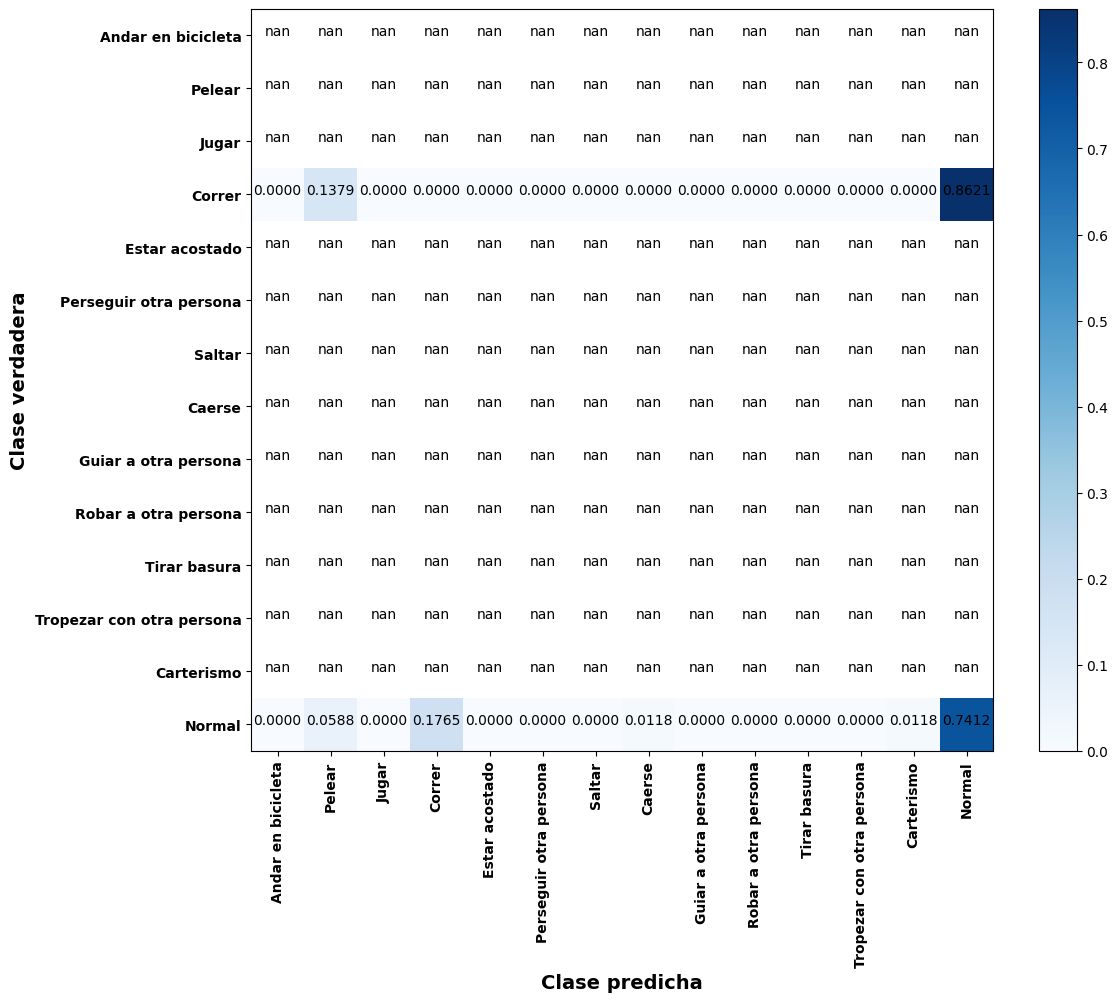

In [ ]:
plt.figure(figsize=(12, 10))
cm_sum = cm_sum / cm_sum.sum(axis=1, keepdims=True)
plt.imshow(cm_sum, interpolation='nearest', cmap=plt.cm.Blues)
#plt.title(f"Matriz de confusión: {mode_names[mode]}", fontsize=16, fontweight='bold')
plt.xlabel("Clase predicha", fontsize=14, fontweight='bold')
plt.ylabel("Clase verdadera", fontsize=14, fontweight='bold')
plt.colorbar()
# Replace class names with the ones from the replace list
replace = [
    "Andar en bicicleta",
    "Pelear",
    "Jugar",
    "Correr",
    'Estar acostado',
    "Perseguir otra persona",
    "Saltar",
    "Caerse",
    "Guiar a otra persona",
    "Robar a otra persona",
    "Tirar basura",
    "Tropezar con otra persona",
    "Carterismo",
    'Normal',
]
updated_classes = replace
tick_marks = np.arange(num_classes)   
plt.xticks(tick_marks, updated_classes, rotation=90, fontweight='bold')  # Rotate x-axis labels for better visibility
plt.yticks(tick_marks, updated_classes, fontweight='bold')   # Annotate the matrix with the values
thresh = cm_sum.max() / 2.0
for i, j in np.ndindex(cm_sum.shape):
    plt.text(j, i, f"{cm_sum[i, j]:.4f}",
                        horizontalalignment="center",
                        color="white" if cm_sum[i, j] > thresh else "black")   
plt.tight_layout()
#plt.savefig(f"CM/confusion_matrix_{mode_names[mode]}.png", bbox_inches='tight')
plt.show()

In [ ]:
df_respaldo=df.copy()
#df_respaldo=df_respaldo.loc[~df_respaldo["Name"].str.endswith("_1")] 
print(df_respaldo)
df_sum = df_respaldo.groupby(["Event", "Mode"])[
    ["TP", "FP", "FN", "TN"]
].sum().reset_index()

# Initialize precision, recall, accuracy with zeros
df_sum["Precision"] = 0.0
df_sum["Recall"] = 0.0
df_sum["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_sum["TP"] + df_sum["FP"]) != 0
df_sum.loc[mask_prec, "Precision"] = (
    df_sum.loc[mask_prec, "TP"] / (df_sum.loc[mask_prec, "TP"] + df_sum.loc[mask_prec, "FP"])
)

mask_recall = (df_sum["TP"] + df_sum["FN"]) != 0
df_sum.loc[mask_recall, "Recall"] = (
    df_sum.loc[mask_recall, "TP"] / (df_sum.loc[mask_recall, "TP"] + df_sum.loc[mask_recall, "FN"])
)

mask_acc = (df_sum["TP"] + df_sum["FP"] + df_sum["FN"] + df_sum["TN"]) != 0
df_sum.loc[mask_acc, "Accuracy"] = (
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "TN"]) /
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "FP"] + df_sum.loc[mask_acc, "FN"] + df_sum.loc[mask_acc, "TN"])
)
df_sum.drop(columns=['TP', 'FP', 'FN', 'TN'], inplace=True)
df_sum['F1'] = 2 * df_sum['Precision'].astype(float) * df_sum['Recall'].astype(float) / (df_sum['Precision'].astype(float) + df_sum['Recall'].astype(float))
df_sum['F1'].fillna(0, inplace=True)  # Handle division by zero
df_sum.drop(columns=['Event'], inplace=True)
df_sum=df_sum.groupby(["Mode"]).mean()
mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
df_sum.rename(index=mode_names, inplace=True)
print(df_sum)

      Name                        Event Mode TP  FP  FN  TN
0  3_090_1  a video of a person running    3  0  15  29  70
     Precision Recall  Accuracy   F1
Mode                                
3          0.0    0.0  0.614035  0.0


/tmp/ipykernel_50483/2034563803.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_prec, "Precision"] = (
/tmp/ipykernel_50483/2034563803.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_recall, "Recall"] = (
/tmp/ipykernel_50483/2034563803.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6140350877192983]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_acc, "Accuracy"] = (
/tmp/ipykernel_50483/2034563803.py:31: FutureWarning: A value is trying t

In [ ]:
def calculate_ap(precision, recall):
    # Sort by recall (ascending)
    sorted_indices = np.argsort(recall)
    precision = np.array(precision)[sorted_indices]
    recall = np.array(recall)[sorted_indices]

    # Pad with (0,0) and (1,0)
    precision = np.concatenate(([0], precision, [0]))
    recall = np.concatenate(([0], recall, [1]))

    # Compute AP as the area under the raw curve (no interpolation)
    ap = 0.0
    for i in range(1, len(recall)):
        delta_recall = recall[i] - recall[i - 1]
        ap += delta_recall * precision[i]

    return ap
df_check = df_respaldo.copy()

# Initialize precision, recall, accuracy with zeros
df_check["Precision"] = 0.0
df_check["Recall"] = 0.0
df_check["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_check["TP"] + df_check["FP"]) != 0
df_check.loc[mask_prec, "Precision"] = (
    df_check.loc[mask_prec, "TP"] / (df_check.loc[mask_prec, "TP"] + df_check.loc[mask_prec, "FP"])
)

mask_recall = (df_check["TP"] + df_check["FN"]) != 0
df_check.loc[mask_recall, "Recall"] = (
    df_check.loc[mask_recall, "TP"] / (df_check.loc[mask_recall, "TP"] + df_check.loc[mask_recall, "FN"])
)

mask_acc = (df_check["TP"] + df_check["FP"] + df_check["FN"] + df_check["TN"]) != 0
df_check.loc[mask_acc, "Accuracy"] = (
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "TN"]) /
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "FP"] + df_check.loc[mask_acc, "FN"] + df_check.loc[mask_acc, "TN"])
)
df_check['F1'] = 2 * df_check['Precision'].astype(float) * df_check['Recall'].astype(float) / (df_check['Precision'].astype(float) + df_check['Recall'].astype(float))
df_check['F1'].fillna(0, inplace=True)  # Handle division by zero
categories = df_check["Event"].unique()
# Separate rows by category
df_check = df_check.copy()
for column in df_check.select_dtypes(include=['category']).columns:
    df_check[column] = df_check[column].astype(str)
df_check.fillna(0, inplace=True)
category_dfs = {category: df_check[df_check["Event"] == category] for category in categories}

mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    #
    grouped = df1.groupby("Mode")
    # ----------------------------------------------------------------------
    # Ejecución del código
    ap_values = {}
    for mode, group in grouped:
        precision = np.array(group["Precision"].values)
        recall = np.array(group["Recall"].values)
        #print("Mode:", mode, "\n")
        #print("Precision:", precision, "Recall:", recall)
        # Comenta la siguiente línea para verificar si el error es aquí
        ap = calculate_ap(precision, recall)
        ap_values[mode] = ap
        #print(f'{mode} {categories[i]} AP: {ap:.4f}')
    mean_values = grouped[["Precision", "Recall",  "F1"]].mean()
    mean_values["AP"] = [ap_values[mode] for mode in mean_values.index]
    mean_values = mean_values[["AP"]]
    mAP_process.append(mean_values)
    # Plot the results
    mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
    mean_values.rename(index=mode_names, inplace=True)
    # plt.xlim(0.4)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values = pd.concat(mAP_process).groupby(level=0).mean()
print(mAP_values)

       AP
Mode     
3     0.0


/tmp/ipykernel_50483/3489928985.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_check.loc[mask_prec, "Precision"] = (
/tmp/ipykernel_50483/3489928985.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_check.loc[mask_recall, "Recall"] = (
/tmp/ipykernel_50483/3489928985.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6140350877192983]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_check.loc[mask_acc, "Accuracy"] = (
/tmp/ipykernel_50483/3489928985.py:42: FutureWarning: A value is tr

In [ ]:
df_fps= pd.read_csv("/home/ubuntu/Tesis/Results/TestingDevM4MC_Score.csv")
print(df_fps["Process time"].sum()/(60*60), "hours\n\n")
df_fps["Process time"] = df_fps["Process time"] / df_fps["Duration"]
df_fps.loc[df_fps["Name"].str.contains("_1.mp4"), "Process time"] = (
        30.0 / df_fps["Process time"]
    )
df_fps.loc[~df_fps["Name"].str.contains("_1.mp4"), "Process time"] = (
        25.0 / df_fps["Process time"]
    )
categories = df_fps["True Event"].unique()
category_dfs = {category: df_fps[df_fps["True Event"] == category] for category in categories}
print(categories)
mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    grouped = df1.groupby("Mode")
    mean_values = grouped[["Process time"]].mean()
    mean_values = mean_values[["Process time"]]
    mAP_process.append(mean_values)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values = pd.concat(mAP_process).groupby(level=0).mean()
print("\n\n", mAP_values)

14.849018954171076 hours


['a video of a person riding a bicycle'
 'a video of a certain number of persons fighting'
 'a video of a group of persons playing' 'a video of a person running']


       Process time
Mode              
3         1.414703
